# 1. Deep learning with Python

## 1.1. Fully connected Neural Network  (2-layer network)

##  Function approximation with fully connected NN

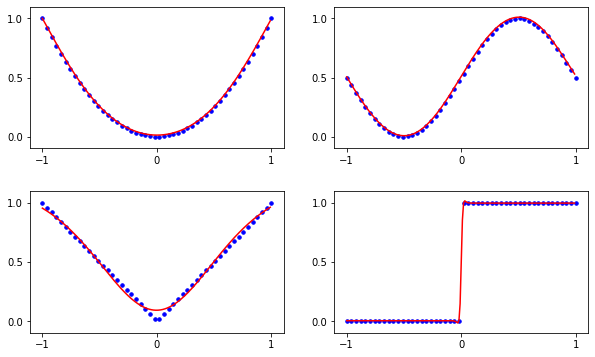

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.nn.two_layer_net import Two_layer_net
from deepL_module.nn.optimizers import *

N = 50 # sample
max_iter = 2000 # iteration num


heaviside = lambda x : 0.5 * (1 + np.sign(x))
sinusoidal = lambda x : 0.5 + 0.5 * np.sin(np.pi * x)


# training data
train_x = np.linspace(-1, 1, N).reshape(N,1)
multi_func = [np.square, sinusoidal, np.abs, heaviside]

# test data
x = np.arange(-1,1,0.01).reshape(-1,1)

fig = plt.figure(figsize=(10, 6))
for n,func in enumerate(multi_func,1):
    
    train_y = func(train_x)
    '''----- plot training data -----'''
    ax = fig.add_subplot(2,2,n)
    ax.scatter(train_x, train_y,s=12,color='blue')
    
    '''----- Constructing NN -----'''
    model = Two_layer_net(1,4,1)
    model.add(['tanh','linear'])
    optimizer = Adam(lr = 0.1, beta_1 = 0.95, beta_2 = 0.95)
    
    '''-----learning------'''
    for _ in range(int(max_iter)):
        grads = model.gradient(train_x,train_y)
        optimizer.update(model.params, grads)

    # prediction data
    y = model.predict(x)
    ax.plot(x, y, 'r-')
    plt.xticks([-1,0,1])
    plt.yticks([0,0.5,1])
    plt.ylim([-0.1, 1.1])
    plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

## Binary class classification using a neural network

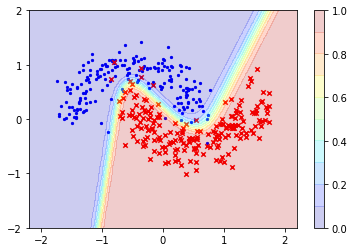

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from deepL_module.nn.two_layer_net import Two_layer_net
from deepL_module.nn.optimizers import *

def create_noise_data(sample:int=400):
    x,labels = make_moons(sample, noise = 0.2)
    x[:,0] -= 0.5
    return x, labels.reshape(-1, 1)


# training dataset
train_x, labels = create_noise_data()

# test dataset
X,Y = np.meshgrid(np.linspace(-3, 3, 100),np.linspace(-3, 3, 100))
test_x = np.array([X.ravel(), Y.ravel()]).reshape(2,-1).T


'''---Constructing the NN---'''
model = Two_layer_net(2,3,1)
model.add(['tanh','sigmoid'])
model.set_loss('sum_squared_error')
optimizer = Adam(lr = 0.1)


'''---Learning the training data---'''
for _ in range(int(250)):
    grads = model.gradient(train_x,labels)
    optimizer.update(model.params, grads)



# plot the training data
plt.scatter(train_x[labels.ravel() == 0,0],
            train_x[labels.ravel() == 0,1],
            marker = ".", s = 20, color = 'b')

plt.scatter(train_x[labels.ravel() == 1,0],
            train_x[labels.ravel() == 1,1],
            marker = "x", s = 20, color = 'r')


# plot the test data
Z = model.predict(test_x)
plt.contourf(X, Y, Z.reshape(X.shape), levels=np.linspace(0, 1, 11), alpha=0.2,cmap='jet')
plt.colorbar()

# axis setting
plt.xlim(-2.2,2.2)
plt.ylim(-2.,2.)
plt.xticks(np.arange(-2,3,1))
plt.yticks(np.arange(-2,3,1))
plt.show()


## 1.2 Comparison of other optimizer

## 1.2.1 Search trajectory drawn by each optimizer

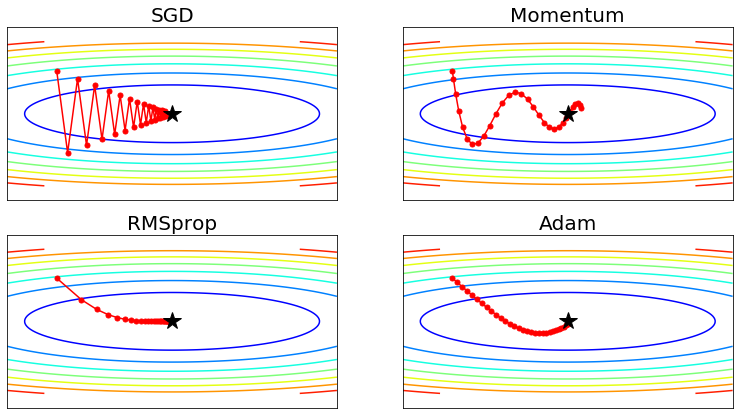

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from deepL_module.nn.optimizers import *


def f(x, y):
    return x ** 2 / 20. + y ** 2


def gradf(x, y):
    return x / 10., 2. * y


X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-5,5,100))
Z = f(X, Y)

init_pos = (-7.0, 3.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["RMSprop"] = RMSprop(lr=0.15)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
fig = plt.figure(figsize=(13,7))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    ax = fig.add_subplot(2,2,idx)


    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = gradf(params['x'], params['y'])
        optimizer.update(params, grads)

    idx += 1
    ax.plot(x_history, y_history, 'o-', color="red",markersize=5,markevery=1)
    ax.contour(X, Y, Z , cmap='jet')
    ax.plot(*np.array([0.,0.]),'r*',markersize=18,color='k')
    plt.ylim(-6, 6)
    plt.xlim(-10, 10)


    plt.title(key,fontsize=20)
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

plt.show()


## 1.2.2 Finding the minimum point of a Beal's function

 > ### Information about Beal's function
 <br>
 Beal's function is a test function for optimization that are useful for evaluating optimization algorithms. It's defined by following:
<br><br>
$$
\begin{align*}
f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
\end{align*}
$$
<br>
<br>
The global minimum point of $f(x,y)$ is calculated to be exactly zero, and the argument is given by 
<br><br>
$$
\begin{align*}
\mathrm{arg}\underset{x,y}{\mathrm{min}}\left[f(x,y)\right]=(3,0.5)
\end{align*}
$$

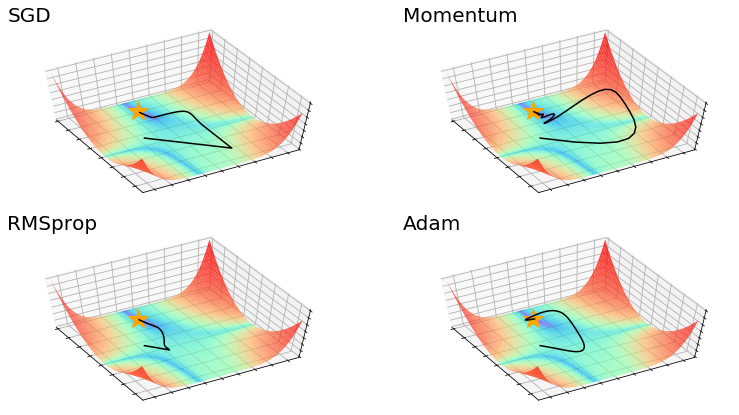

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from deepL_module.base.functions import *
from deepL_module.nn.optimizers import *
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D


init_pos = np.array([0.6,1.7]).astype(float)
minimum = np.array([3.,0.5])

params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.05)
optimizers["Momentum"] = Momentum(lr=0.02,momentum=0.8)
optimizers["RMSprop"] = RMSprop(lr=0.2,rho=0.95)
optimizers["Adam"] = Adam(lr=0.2,beta_1=0.97,beta_2=0.99)

idx = 1
fig = plt.figure(figsize=(13,7))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    ax = fig.add_subplot(2,2,idx,projection='3d')
    ax.view_init(elev=60,azim=150)
    train_x, train_y = np.linspace(-3.5,4.,100), np.linspace(-4.5,4.5,100)
    X, Y = np.meshgrid(train_x,train_y)
    Z = beal_function(X, Y)
    ax.plot_surface(X,Y,Z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap='rainbow')
    ax.plot([3.],[0.5], beal_function(3,0.5), 'r*', markersize=20,color='orange',zorder=3)

    for i in range(90):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = grad_beal(params['x'], params['y'])
        optimizer.update(params, grads)

    idx += 1
    ax.plot(x_history, y_history, '-',marker='.', color="k",markersize=0,markevery=7,zorder=3)
    plt.ylim(-4.5, 4.5)
    plt.xlim(-3.5, 4.)
    plt.title(key,fontsize=20,loc='left')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

plt.show()

## Overview

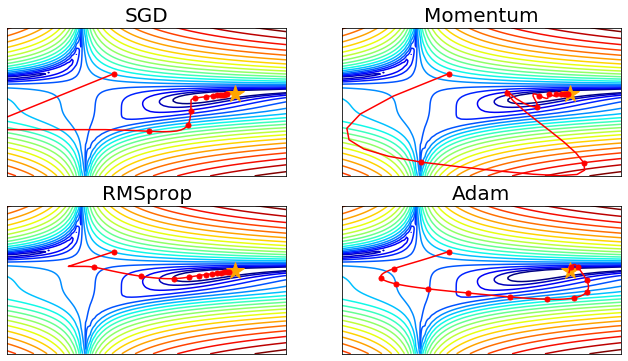

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from deepL_module.base.functions import *
from deepL_module.nn.optimizers import *
from collections import OrderedDict


init_pos = np.array([0.6,1.7]).astype(float)

params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.05)
optimizers["Momentum"] = Momentum(lr=0.02,momentum=0.8)
optimizers["RMSprop"] = RMSprop(lr=0.2,rho=0.95)
optimizers["Adam"] = Adam(lr=0.2,beta_1=0.97,beta_2=0.99)

idx = 1
fig = plt.figure(figsize=(11,6))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    ax = fig.add_subplot(2, 2, idx)
    train_x, train_y = np.linspace(-4.5,4.5,100), np.linspace(-4.5,4.5,100)
    X, Y = np.meshgrid(train_x,train_y)
    Z = beal_function(X, Y)
    ax.contour(X, Y, Z, levels=np.logspace(0,5,20), norm=LogNorm(), cmap='jet')
    ax.plot(*np.array([3,0.5]),'r*',markersize=18,color='orange')

    for i in range(90):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = grad_beal(params['x'], params['y'])
        optimizer.update(params, grads)

    idx += 1
    path = np.array([x_history,y_history])
    path = path.T[::2].T
    ax.plot(x_history, y_history, 'o-', color="r",markersize=5,markevery=7)
    plt.ylim(-4.5, 4.5)
    plt.xlim(-1.5, 4.)
    plt.title(key,fontsize=20)
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

plt.show()

## 1.2.3 Comparison of optimizers for MNIST datasets


===========iteration:  0===========
method:SGD              loss:4.6709
method:Momentum         loss:5.71
method:Adagrad          loss:5.1733
method:RMSprop          loss:4.3789
method:Adam             loss:6.9941

===========iteration:200===========
method:SGD              loss:2.2556
method:Momentum         loss:2.3123
method:Adagrad          loss:3.1208
method:RMSprop          loss:2.2338
method:Adam             loss:2.289

===========iteration:400===========
method:SGD              loss:2.2803
method:Momentum         loss:2.2387
method:Adagrad          loss:2.3418
method:RMSprop          loss:2.2537
method:Adam             loss:2.3884

===========iteration:600===========
method:SGD              loss:2.2887
method:Momentum         loss:2.4991
method:Adagrad          loss:2.6211
method:RMSprop          loss:2.2722
method:Adam             loss:2.305

===========iteration:800===========
method:SGD              loss:2.2953
method:Momentum         loss:2.2899
method:Adagrad          los

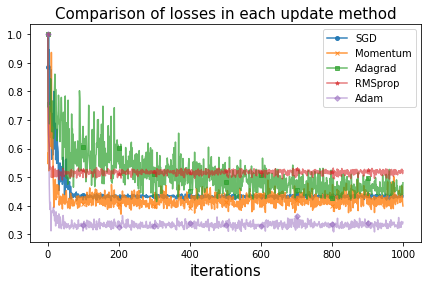

In [6]:
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.nn.two_layer_net import Two_layer_net
from deepL_module.nn.optimizers import *
from deepL_module.nn.cost_functions import *
from deepL_module.base.functions import *

# === loading data ===
(X_train, train_t), (X_test, test_t) = load_mnist(normalize=True)

train_size = X_train.shape[0]
batch_size = 32
max_iter = 1000


# === config for optimizer ===
optimizers = {}
optimizers['SGD'] = SGD(lr = 0.01)
optimizers['Momentum'] = Momentum(lr=0.02)
optimizers['Adagrad'] = Adagrad(lr=0.001)
optimizers['RMSprop'] = RMSprop(lr=0.001)
optimizers['Adam'] = Adam(lr = 0.005)


model = {}
train_loss = {}
for key in optimizers.keys():
    model[key] = Two_layer_net(784,100,10)
    model[key].add(['tanh','linear'])
    model[key].set_loss('categorical_crossentropy')
    train_loss[key] = []


# === learning ===
for i in range(max_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    t_batch = to_categorical(train_t[batch_mask],10)

    for key in optimizers.keys():
        grads = model[key].gradient(x_batch, t_batch)
        optimizers[key].update(model[key].params, grads)

        loss = model[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 200 == 0:
        print( "\n===========" + "iteration:" + str(i).rjust(3) + "===========")
        for key in optimizers.keys():
            loss = model[key].loss(x_batch, t_batch)
            print('method:' + key + 'loss:{:.5g}'.rjust(28-len(key)).format(loss))


# === drawing loss data ===
markers = {"SGD": "o", "Momentum": "x", "Adagrad": "s", "RMSprop": "*", "Adam": "D"}
fig=plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
x = np.arange(max_iter)
for n,key in enumerate(optimizers.keys(),1):
    norm = np.max(train_loss[key])
    ax.plot(x, train_loss[key] / norm, marker=markers[key],markersize=4, markevery=100, label=key, zorder=n, alpha=1-0.1*n)
plt.xlabel("iterations",fontsize=15)
plt.title("Comparison of losses in each update method",fontsize=15)
plt.legend(fontsize=10,bbox_to_anchor=(1, 1), loc='upper right',)
plt.show()